In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from svgpath2mpl import parse_path
from scipy import signal

%matplotlib inline

In [3]:
DURATION_SHORTS = 61
DURATION_LONG = 600

def getCategoryLabel(k):
    lbs = k.split(" ")
    if len(lbs) > 1:
        lb = ''.join([l[0] if l[0] != '&' else '' for l in lbs])
    else:
        lb = lbs[0][:2]
    return lb

In [77]:
data_df = pd.read_csv("../dataset/youtube.csv",
            dtype={"id": "string", "publishedAt": "string",
                "title": "string", "categoryId": "string",
                "duration": int, "viewCount": int, 
                "countryCode": "string", "date": "string", "retentionCurve": "string"})
age_df = pd.read_csv("../dataset/youtube_video_age.csv")

In [78]:
data_df

,id,publishedAt,title,categoryId,duration,viewCount,countryCode,date,retentionCurve
0,gMB5olLmryo,2022-10-26T16:27:13Z,CRAZY DIWALI EXPERIMENTS! (MythReacts #5),Entertainment,694,1771911,IN,2022-10-28,"M 0.0,100.0 C 1.0,80.9 2.0,13.3 5.0,4.5 C 8.0,..."
1,Qg9LxRHLbAk,2022-10-26T05:30:04Z,KR$NA - I Guess | Official Music Video,Music,186,2348145,IN,2022-10-28,"M 0.0,100.0 C 1.0,94.4 2.0,75.0 5.0,71.9 C 8.0..."
2,z3TKq9LVbzM,2022-10-26T01:15:11Z,उगी सुरुज देव | #Pawan Singh New Chhath Geet V...,Music,279,5726120,IN,2022-10-28,"M 0.0,100.0 C 1.0,94.5 2.0,74.5 5.0,72.5 C 8.0..."
3,ygaK4BQaACk,2022-10-26T12:30:09Z,Varisu Director Vamshi Paidipally 1st ever Exc...,Entertainment,1605,722371,IN,2022-10-28,"M 0.0,100.0 C 1.0,93.3 2.0,70.2 5.0,66.6 C 8.0..."
4,i0ZHTiDTS30,2022-10-24T10:30:11Z,Meet Dr. Vikas Divyakirti | Episode 50,People & Blogs,1588,6417618,IN,2022-10-28,"M 0.0,100.0 C 1.0,92.5 2.0,69.6 5.0,62.7 C 8.0..."
...,...,...,...,...,...,...,...,...,...
199036,ujghTTXDvSo,2023-12-04T02:10:59Z,[11-12회 몰아보기] ＂당신 손목에 그거 뭐야?＂ 정유민과 똑같이 회귀했던 성...,Entertainment,1695,285284,KR,2023-12-07,"M 0.0,100.0 C 1.0,97.3 2.0,88.5 5.0,86.5 C 8.0..."
199037,4IQDjHG77BY,2023-12-02T11:00:03Z,[#조선의사랑꾼] 축 아들 탄생🎉 첫 임신 소식 전하는 54세 아빠 최성국 몰아보기...,Entertainment,2692,328935,KR,2023-12-07,"M 0.0,100.0 C 1.0,98.0 2.0,92.0 5.0,90.0 C 8.0..."
199038,jp-c7dKomsA,2023-11-28T11:36:51Z,Would you win?!😅,People & Blogs,39,2195199,ES,2023-12-07,"M 0.0,100.0 C 1.0,80.0 2.0,19.0 5.0,0.0 C 8.0,..."
199039,RQ9qwVDvqcM,2023-11-14T09:19:30Z,王家幫幫主：看見小夥伴大公雞被宰、進了鍋裏，巴圖眼睛裏都是悲傷，都蔫了#shorts,People & Blogs,43,4145821,ES,2023-12-07,"M 0.0,100.0 C 1.0,80.0 2.0,20.0 5.0,0.0 C 8.0,..."


In [80]:
## get the counts of each category/country
category = ['Entertainment', 'Gaming', 'People & Blogs',
            'Sports', 'Music', 'News & Politics',
            'Comedy', 'Film & Animation', 'Howto & Style',
            'Autos & Vehicles', 'Education', 'Science & Technology',
            'Travel & Events', 'Pets & Animals', 'Nonprofits & Activism']
country = ['RU', 'IN', 'TH', 'ES', 'FR', 'IT', 'US', 'DE', 'BR', 'TR',
           'JP', 'ID', 'KR', 'MX', 'GB', 'EG', 'PH', 'VN', 'PK', 'BD']

#for c in category:
#    print(f"{c}: {data_df['categoryId'].value_counts()[c]}")
#print()
#for c in country:
#    print(f"{c}: {data_df['countryCode'].value_counts()[c]}")

In [128]:
counts_country = {}
for index, entry in age_df.iterrows():
    key_ca = entry['categoryId']
    view_count = entry['viewCount'].split(";")
    country_code = entry['countryCode'].split(";")
    for rc in country_code:
        category_ids = counts_region.get(rc, {})
        category_id = category_ids.get(key_ca, [])
        category_id.append([len(view_count), int(view_count[-1])])
        category_ids[key_ca] = category_id
        counts_country[rc] = category_ids

In [129]:
def getStatistics(v):
    v_ary = np.array(v)
    age = np.median(v_ary[:,0])
    views_avg = np.mean(v_ary[:,1])
    #print("{} {:.2f}".format(age, views_avg))
    return [age, views_avg]

def sortResults(results_r, shorten_key=False):
    results_r.sort(key = lambda x: (x[1], x[2]))
    x_labels, ages, views = [], [], []
    for r in results_r:
        if shorten_key:
            x_labels += [getCategoryLabel(r[0])]
        else:
            x_labels += [r[0]]
        ages += [r[1]]
        views += [r[2]]
    #print(results_r)
    return x_labels, ages, views

results_r, results_total = [], []
for key, value in counts_country.items():
    total = []
    for k, v in value.items():
        total += v
        results_total.append([key+','+k]+getStatistics(v)+[len(v)])
    results_r.append([key]+getStatistics(total)+[len(total)])
x_labels, ages, views = sortResults(results_r)

In [70]:
#for k, v in counts_region['IN'].items():
#    print("{}: {}, {:.2f}".format(k, len(v), np.median(v, axis=0)[0]))

In [130]:
results_c, tmp = [], {}
for key, value in counts_country.items():
    for k, v in value.items():
        total = tmp.get(k, [])
        total += v
        tmp[k] = total
for key, value in tmp.items():
    results_c.append([key]+getStatistics(value)+[len(value)])
x_labels_c, ages_c, views_c = sortResults(results_c, shorten_key=True)

In [131]:
def plotAge(plot_set, size=(24, 4)):
    fig = plt.figure(figsize=size)
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'font.family': 'sans-serif'})
    plt.rcParams.update({'font.sans-serif': 'Verdana'})
    plt.rcParams.update({'pdf.fonttype': 42})
    plt.rcParams.update({'ps.fonttype': 42})

    for idx, (x_label, data) in enumerate(plot_set.items()):
        ax = fig.add_subplot(1, 2, idx+1)
        x_labels, ages, views, pos = data
        bp1 = ax.plot(ages, lw=4)
        if idx == 0:
            ax.set_ylabel('Median Popularity\n Age (days)', fontsize=20, fontweight='bold')
        plt.grid(linestyle=":")
        plt.xticks([i for i in range(len(x_labels))], x_labels, fontsize=20, fontweight='bold')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        #plt.ylim([1.1, 1.3])

        ax2 = ax.twinx()
        if idx == 1:
            ax2.set_ylabel('Avg. View Counts\n(million)', color='g', fontsize=20, fontweight='bold')
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        bp3 = ax2.plot(np.array(views)/1e6, 'g--', lw=4)
        plt.yticks(fontsize=20, color='g')

        plt.legend([bp1[0], bp3[0]], ['Median Popularity Age', 'Avg. View Counts'], 
                   loc='upper left', ncol=1)
        plt.text(pos[0], pos[1], x_label, fontsize=20, fontweight='bold')
    plt.tight_layout()
    #plt.savefig('../artifacts/video_age.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()

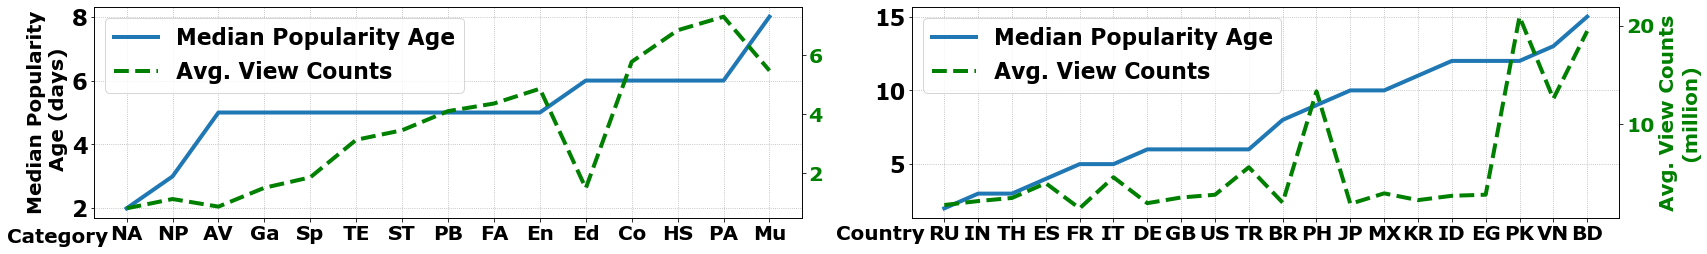

In [132]:
## 2.2.1 Duration of Popularity
plot_set = {}
plot_set["Category"] = (x_labels_c, ages_c, views_c, [-2.6, -0.35])
plot_set["Country"] = (x_labels, ages, views, [-3.2, -1.8])
plotAge(plot_set)

In [133]:
## YouTube shorts (<= 60s)
duration_by_country, duration_by_category = {}, {}

for index, entry in data_df.iterrows():
    region = duration_by_country.get(entry['countryCode'], [0, 0, 0])
    category = duration_by_category.get(entry['categoryId'], [0, 0, 0])
    region[2] += 1
    category[2] += 1
    if entry['duration'] > DURATION_LONG:
        region[0] += 1
        category[0] += 1
    elif entry['duration'] > DURATION_SHORTS and entry['duration'] <= DURATION_LONG:
        region[1] += 1
        category[1] += 1
    duration_by_country[entry['countryCode']] = region
    duration_by_category[entry['categoryId']] = category

In [134]:
def plot_stacks(categoryIds, countryCodes, degree=70,
                size=(24,4), classes=['YouTube (10+ mins)', 
                                      'YouTube ($\leq$ 10 mins)', 
                                      'YouTube Shorts ($\leq$ 60 secs)']):
    width = 0.35
    fig = plt.figure(figsize=size)
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'font.family': 'sans-serif'})
    plt.rcParams.update({'font.sans-serif': 'Verdana'})
    plt.rcParams.update({'pdf.fonttype': 42})
    plt.rcParams.update({'ps.fonttype': 42})

    data_tmp = {'Category': categoryIds, 'Country': countryCodes}
    for idx, (title, data) in enumerate(data_tmp.items()):
        ax = fig.add_subplot(1, 2, idx+1)
        labels, greater, less, longs, greats = [], [], [], [], []
        for k, v in data.items():
            long, great = v[0]/v[2], v[1]/v[2]
            labels.append(getCategoryLabel(k))
            longs.append(long)
            greater.append(long+great)
            greats.append(great)
            less.append(1-long-great)
        greater, labels, less, longs, greats = zip(*sorted(
            zip(greater, labels, less, longs, greats), key=lambda x: (x[3], x[0])))
        ax.bar(labels, longs, width, label=classes[0], hatch='//', color='#7B68EE')
        ax.bar(labels, greats, width, bottom=longs, label=classes[1], hatch='\\', color='#DAA520')
        ax.bar(labels, less, width, bottom=greater, label=classes[2], hatch='/', color='#20B2AA')

        if idx == 0: ax.set_ylabel('Normalized Counts', fontsize=20, fontweight='bold')
        #ax.set_title(title, fontsize=22, fontweight='bold')
        #ax.legend(fontsize=20, loc='lower right')
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2, 1, 0]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, loc='lower right')
        
        ax.grid(linestyle=":")
        ax.tick_params(axis="both", labelsize=20)
        #plt.setp(ax.get_xticklabels(), rotation=degree, horizontalalignment='right')
        if idx == 0: plt.text(-2.55, -0.12, title, fontsize=20, fontweight='bold')
        else: plt.text(-3, -0.12, title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    #plt.savefig('../artifacts/video_length.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()

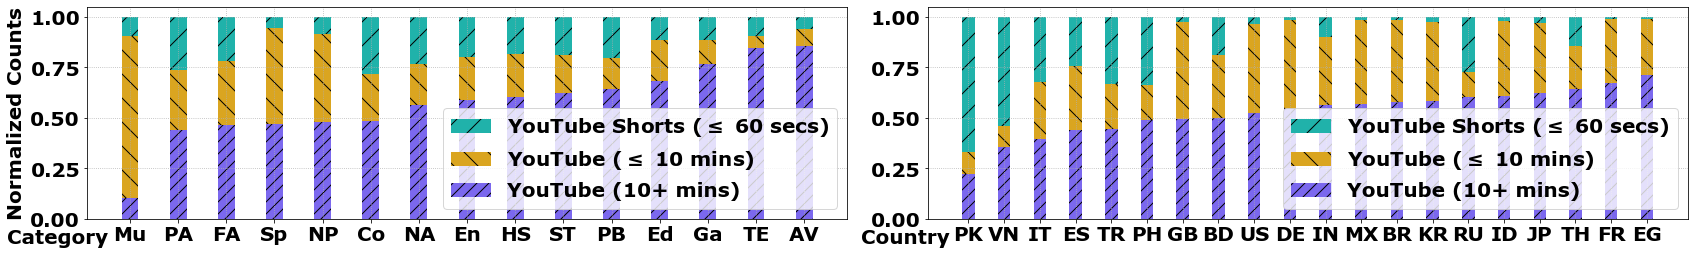

In [135]:
## 2.2.2 Video Length
plot_stacks(duration_by_category, duration_by_country)

#### Q2: YouTube Shorts (<= 60s)
* Shorts are very popular in PK and VN.
* At least 20% of videos of PA (Pets & Animals) and Co (Comedy) are Shorts.

We are interested in `long` videos (> 60s).

In [136]:
durations = data_df.set_index('id').to_dict()['duration']
counts_country = {}
for index, entry in age_df.iterrows():
    if entry['id'] not in durations.keys() or durations[entry['id']] <= DURATION_SHORTS: continue
    key_ca = entry['categoryId']
    view_count = entry['viewCount'].split(";")
    country_code = entry['countryCode'].split(";")
    for rc in country_code:
        category_ids = counts_country.get(rc, {})
        category_id = category_ids.get(key_ca, [])
        category_id.append([len(view_count), int(view_count[-1])])
        category_ids[key_ca] = category_id
        counts_country[rc] = category_ids

In [137]:
results_total = []
for key, value in counts_country.items():
    total = []
    for k, v in value.items():
        total += v
        results_total.append([key+','+k]+getStatistics(v)+[len(v)])

In [138]:
def convertToPoints(svg_path, duration, debug=False):
    path = parse_path(svg_path)
    coordinates = np.array(path.to_polygons(closed_only=False))
    coordinates[0][:,1] = 100.0-coordinates[0][:,1]
    data = coordinates.T[:,:,0].tolist()
    x, y = data[0]/np.max(data[0])*duration, data[1]
    f = interp1d(x, y)
    xnew = np.arange(0, duration)
    ynew = f(xnew)
    return ynew.tolist()

In [145]:
xnew = np.arange(0, 1, 0.1)+0.1
auc_by_country, auc_by_category = {}, {}

for index, entry in data_df.iterrows():
    country = auc_by_country.get(entry['countryCode'], [])
    category = auc_by_category.get(entry['categoryId'], [])
    if entry['duration'] > DURATION_SHORTS:
    #if entry['duration'] <= DURATION_SHORTS and entry['duration'] > 5:
        curve = convertToPoints(entry['retentionCurve'], entry['duration'])[1:]
        n = len(curve)
        x = np.array([(i+1)/n for i in range(n)])
        y = np.array(curve)
        f = interp1d(x, y, fill_value="extrapolate")
        ynew = f(xnew)
        ynew[ynew < 0] = 0
        ynew = ynew.tolist()
        region.append(ynew)
        category.append(ynew)
        auc_by_country[entry['countryCode']] = country
        auc_by_category[entry['categoryId']] = category

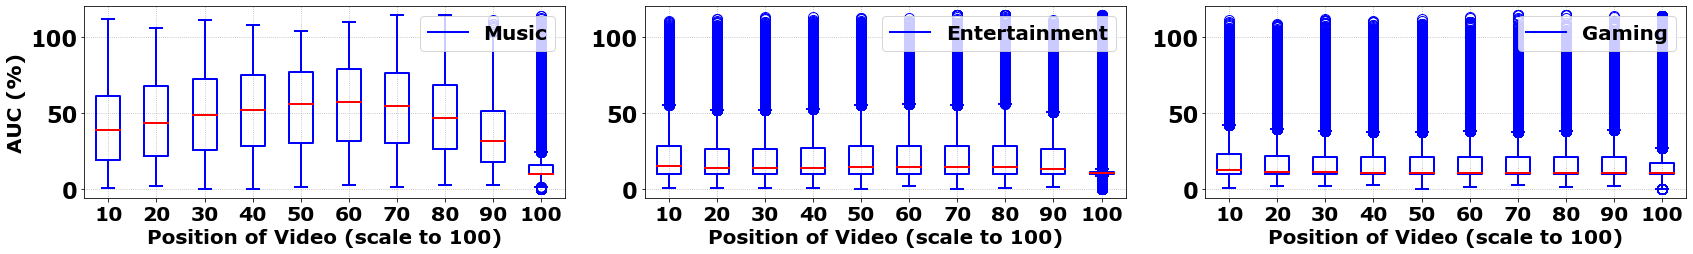

In [146]:
## 2.2.3 Area under Audience Retention Curve (AUC)
topn = 1
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 2, 2]}, 
                       figsize=(24,4))
#fig.tight_layout()
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'Verdana'})
plt.rcParams.update({'pdf.fonttype': 42})
plt.rcParams.update({'ps.fonttype': 42})
for idx, key in enumerate(['Music', 'Entertainment', 'Gaming']):
    ary = np.array(auc_by_category[key])
    bp1 = ax[idx].boxplot(ary, boxprops=dict(linewidth=2.0, color='blue'), 
        whiskerprops=dict(linewidth=2.0, color='blue'),
        medianprops=dict(linewidth=2.0, color='red'),
        capprops=dict(linewidth=2.0, color='blue'),
        flierprops=dict(marker='o', markersize=10,
        linestyle='none', markeredgecolor='b'))
    if idx == 0:
        ax[idx].set_ylabel("AUC (%)", fontsize=20, fontweight='bold')
    ax[idx].set_xlabel("Position of Video (scale to 100)", fontsize=20, fontweight='bold')
    ax[idx].set_xticklabels([(i+1)*10 for i in range(10)], fontsize=20, fontweight='bold')
    #ax[idx].set_ylim([-5, 100])
    ax[idx].legend([bp1["boxes"][0]], [key], fontsize=20, loc='upper right')
    ax[idx].grid(linestyle=":")

plt.tight_layout()
plt.savefig('../artifacts/norm_video_length.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
#plt.savefig('../artifacts/norm_video_length_short.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()

In [116]:
peak_by_country, peak_by_category = {}, {}
peaks = {}
widths = np.arange(10,100)
for index, entry in data_df.iterrows():
    if entry['duration'] > DURATION_SHORTS:
        country = peak_by_country.get(entry['countryCode'], {})
        category = peak_by_category.get(entry['categoryId'], {})
        
        curve = convertToPoints(entry['retentionCurve'], entry['duration'])
        peakind = signal.find_peaks_cwt(curve, widths)
        n_peak = len(peakind)
        peaks[entry['id']] = n_peak
        
        country[n_peak] = country.get(n_peak, 0) + 1
        category[n_peak] = category.get(n_peak, 0) + 1
        peak_by_country[entry['countryCode']] = country
        peak_by_category[entry['categoryId']] = category
        if index % 10000 == 0: print("finished {}".format(index))

finished 0
finished 10000
finished 20000
finished 30000
finished 40000
finished 50000
finished 60000
finished 70000
finished 80000
finished 90000
finished 100000
finished 110000
finished 120000
finished 140000
finished 160000
finished 170000
finished 180000
finished 190000


In [121]:
def getCounts(peak_by_category, COUNT=6, INDEX=None):
    results = {}
    for k, v in peak_by_category.items():
        counts = [0 for i in range(COUNT)]
        for peak, count in v.items():
            if peak >= COUNT:
                counts[COUNT-1] += count
            else:
                counts[peak-1] += count
        results[k] = np.array(counts)/np.sum(counts)
    if INDEX == None:
        results = dict(sorted(results.items(), key=lambda item: item[1][COUNT-1]))
    else:
        results = dict(sorted(results.items(), key=lambda item: np.sum(item[1][INDEX:])))
    #print(results)
    return results

def plotPeakStack(plot_sets, size=(24,4), width=0.35, COUNT=6,
                  UNIT="spike", LOC='upper right', NCOL=2):
    fig = plt.figure(figsize=size)
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'font.family': 'sans-serif'})
    plt.rcParams.update({'font.sans-serif': 'Verdana'})
    plt.rcParams.update({'pdf.fonttype': 42})
    plt.rcParams.update({'ps.fonttype': 42})

    cls = [('0.5', None), ('#80D8FF', '/'), ('#F4FF81', '\\'),
           ('#FF80AB', '//'), ('#FFD180', '\\'), ('#E0E0E0', '/')]
    for index, (title, data) in enumerate(plot_sets.items()):
        ax = fig.add_subplot(1, len(plot_sets), 1+index)
        labels, counts = [], np.zeros((COUNT, len(data)))
        for idx, (k, v) in enumerate(data.items()):
            labels.append(getCategoryLabel(k))
            for i in range(len(v)):
                counts[i, idx] = v[i]

        for idx in range(COUNT):
            classes = "{} {}".format(idx+1, UNIT)
            if idx > 0: classes += 's'
            if idx == COUNT-1: classes = '{}+ {}s'.format(idx+1, UNIT)
            if idx == 0:
                ax.bar(labels, counts[idx,:], width, label=classes,
                       ls='--', edgecolor='black', error_kw=dict(capsize=12),
                       hatch=cls[idx][1], color=cls[idx][0])
            else:
                ax.bar(labels, counts[idx,:], width, bottom=np.sum(counts[:idx,:], axis=0),
                       ls='--', edgecolor='black', error_kw=dict(capsize=12),
                       label=classes, hatch=cls[idx][1], color=cls[idx][0])
        ax.grid(linestyle=":")
        if index == 0: ax.set_ylabel('Normalized Counts', fontsize=20, fontweight='bold')
        #ax.set_title(title, fontsize=22, fontweight='bold')
        ax.legend(fontsize=20, loc=LOC, ncol=int(COUNT/NCOL))
        ax.tick_params(axis="both", labelsize=20)
        #plt.setp(ax.get_xticklabels(), rotation=degree, horizontalalignment='right')
        if index == 0: plt.text(-2.55, -0.12, title, fontsize=20, fontweight='bold')
        else: plt.text(-3, -0.12, title, fontsize=20, fontweight='bold')
        #plt.ylim([0, 1.13])
    plt.tight_layout()
    plt.savefig('../artifacts/video_spikes.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()
    
peak_show_by_category = getCounts(peak_by_category)
peak_show_by_country = getCounts(peak_by_country)

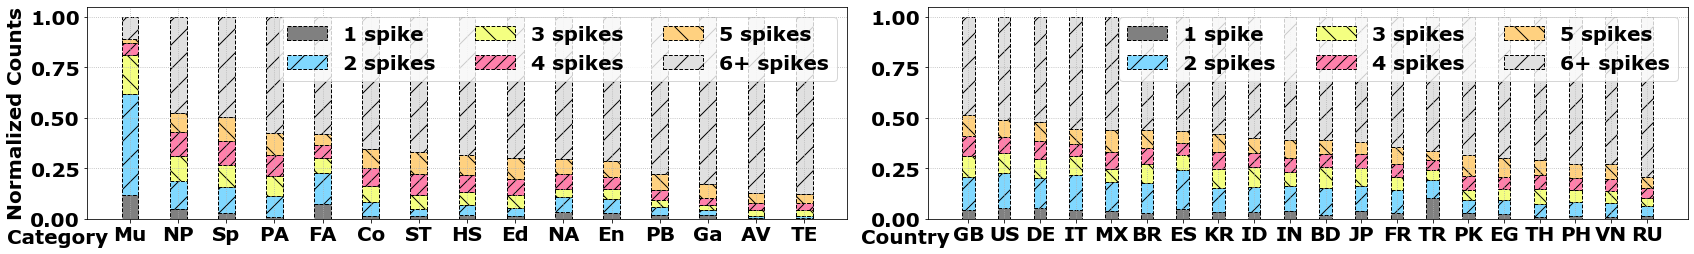

In [122]:
## 2.2.4 Spikes of Retention Curve
plot_sets = {}
plot_sets['Category'] = peak_show_by_category
plot_sets['Country'] = peak_show_by_country
plotPeakStack(plot_sets)

In [123]:
def countVideoLength(entry, duration_by_category, value=1, n_count=3):
    category = duration_by_category.get(entry['categoryId'], [0 for i in range(n_count)])
    if n_count == 4:
        category[3] += 1
    if entry['duration'] > DURATION_LONG:
        category[0] += value
    elif entry['duration'] > DURATION_SHORTS and entry['duration'] <= DURATION_LONG:
        category[1] += value
    else:
        category[2] += value
    duration_by_category[entry['categoryId']] = category
    return duration_by_category

duration_by_category_pk, duration_by_category_ru = {}, {}
viewcount_by_category_pk, viewcount_by_category_ru = {}, {}
for index, entry in data_df.iterrows():
    if entry['countryCode'] == 'PK':
        view_count = int(age_df[age_df['id']==entry['id']]['viewCount'].values[0].split(";")[-1])
        duration_by_category_pk = countVideoLength(entry, duration_by_category_pk)
        viewcount_by_category_pk = countVideoLength(entry, viewcount_by_category_pk,
                                                    value=view_count, n_count=4)
    elif entry['countryCode'] == 'RU':
        view_count = int(age_df[age_df['id']==entry['id']]['viewCount'].values[0].split(";")[-1])
        duration_by_category_ru = countVideoLength(entry, duration_by_category_ru)
        viewcount_by_category_ru = countVideoLength(entry, viewcount_by_category_ru,
                                                    value=view_count, n_count=4)

In [124]:
def plot_stacks_per_country(categoryIds, regionCodes, degree=70, size=(12,3.5),
                            classes=['YouTube (10+ mins)', 
                                     'YouTube ($\leq$ 10 mins)', 
                                     'YouTube Shorts ($\leq$ 60 secs)'],
                            n_show=3, width=0.35):
    fig = plt.figure(figsize=size)
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'font.family': 'sans-serif'})
    plt.rcParams.update({'font.sans-serif': 'Verdana'})
    plt.rcParams.update({'pdf.fonttype': 42})
    plt.rcParams.update({'ps.fonttype': 42})

    data_tmp = {'RU': categoryIds, 'PK': regionCodes}
    for idx, (title, data) in enumerate(data_tmp.items()):
        ax = fig.add_subplot(1, 2, idx+1)
        labels, greater, less, longs, greats = [], [], [], [], []
        for k, v in data.items():
            if len(v) == 4:
                denominator = v[3]*1e6
            else:
                denominator = 1*1e3
            long, great = v[0]/denominator, v[1]/denominator
            labels.append(getCategoryLabel(k))
            longs.append(long)
            greater.append(long+great)
            greats.append(great)
            less.append(v[2]/denominator)
        greater, labels, less, longs, greats = zip(*sorted(
            zip(greater, labels, less, longs, greats), key=lambda x: (x[0]+x[2]), reverse=True))
        ax.bar(labels[:n_show], longs[:n_show], width,
               label=classes[0], hatch='//', color='#7B68EE')
        ax.bar(labels[:n_show], greats[:n_show], width,
               bottom=longs[:n_show], label=classes[1], hatch='\\', color='#DAA520')
        ax.bar(labels[:n_show], less[:n_show], width,
               bottom=greater[:n_show], label=classes[2], hatch='/', color='#20B2AA')

        if idx == 0:
            ax.set_ylabel('Counts (thousand)', fontsize=16, fontweight='bold')
        else:
            ax.set_ylabel('Avg. View Counts\n(million)', fontsize=16, fontweight='bold')
        #ax.set_title(title, fontsize=22, fontweight='bold')
        #ax.legend(fontsize=18, loc='upper right')
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2, 1, 0]
        if idx == 0:
            fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                  fontsize=14, loc='upper center', ncol=3, bbox_to_anchor =(0.53, 1.06))
        
        ax.grid(linestyle=":")
        ax.tick_params(axis="both", labelsize=16)
        #plt.setp(ax.get_xticklabels(), rotation=degree, horizontalalignment='right')
        if idx == 0:
            plt.text(-0.45, -0.7, title, fontsize=16, fontweight='bold')
            #plt.ylim([0, 6.0])
        else:
            plt.text(-0.45, -9, title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../artifacts/ru_pk_breakdown.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()

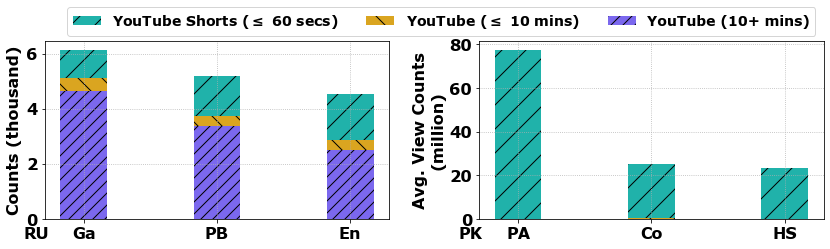

In [125]:
## 2.2.1 Duration of Popularity=
plot_stacks_per_country(duration_by_category_ru, viewcount_by_category_pk)